In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

import os
import numpy as np
import pandas as pd

from sklearn import datasets, model_selection 
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
svhn = tfds.load('svhn_cropped')

In [3]:
import imageio
from skimage.transform import resize

svhn_train, svhn_test = svhn['train'], svhn['test']

In [4]:
x_train = []
y_train = []

for tensor in tfds.as_numpy(svhn_train):

    img = tensor['image']
    label = np.array(tensor['label']).astype(np.int64)

    x_train.append(img)
    y_train.append(label)

x_test = []
y_test = []

for tensor in tfds.as_numpy(svhn_test):

    # img = resize(tensor['image'], (190//1.5, 89//1.5))
    img = tensor['image']
    label = np.array(tensor['label']).astype(np.int64)

    x_test.append(img)
    y_test.append(label)


In [5]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

73257
73257
26032
26032


In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(73257,)
(26032, 32, 32, 3)
(26032,)


In [10]:
np.save('data/svhn/x_train', x_train)
np.save('data/svhn/y_train', y_train)
np.save('data/svhn/x_test', x_test)
np.save('data/svhn/y_test', y_test)

## 여기서부터 실행 가능
## 이전 코드들은 tensorflow datasets에서 데이터셋을 만드는 과정을 포함

In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers

import os
import numpy as np
import pandas as pd

from sklearn import datasets, model_selection 
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [36]:
def load_crop_svhn_data():
    x_train = np.load('data/svhn/x_train.npy')
    y_train = np.load('data/svhn/y_train.npy')
    x_test  = np.load('data/svhn/x_test.npy')
    y_test  = np.load('data/svhn/y_test.npy')
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_crop_svhn_data()

In [37]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(73257,)
(26032, 32, 32, 3)
(26032,)


In [39]:
print(y_train.min())
print(y_train.max())
print(y_test.min())
print(y_test.max())

0
9
0
9


In [40]:
def show(idx):
    plt.imshow(x_train[idx])
    plt.title(f'label: {y_train[idx]}')
    plt.show()

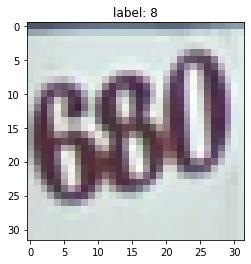

In [41]:
show(1)

C:\Users\angel\AppData\Local\Temp\ipykernel_33664\2493146104.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 73257 + 1) instead
  rand = np.random.random_integers(len(x_train), size=(10,))


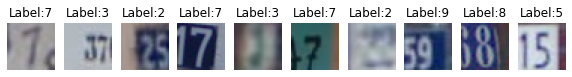

In [42]:
rand = np.random.random_integers(len(x_train), size=(10,))
random_test_labels = y_train[rand] 

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
# fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, label in enumerate(random_test_labels):
    idx = rand[i]
    ax[i].set_axis_off()
    ax[i].imshow(x_train[idx])
    ax[i].set_title(f'Label:{label}')

plt.show()

In [43]:
# retain the channel dimension, which will now have size 1.
x_train_gray = np.mean(x_train, axis=3)
x_test_gray = np.mean(x_test, axis=3)
print(x_train_gray.shape)
print(x_test_gray.shape)

(73257, 32, 32)
(26032, 32, 32)


C:\Users\angel\AppData\Local\Temp\ipykernel_33664\4291275114.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 73257 + 1) instead
  rand = np.random.random_integers(len(x_train_gray), size=(10,))


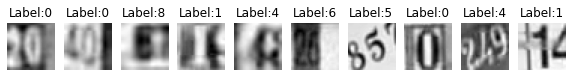

In [44]:
rand = np.random.random_integers(len(x_train_gray), size=(10,))
random_test_labels = y_train[rand] 

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
# fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, label in enumerate(random_test_labels):
    idx = rand[i]
    ax[i].set_axis_off()
    ax[i].imshow(x_train_gray[idx], cmap='gray')
    ax[i].set_title(f'Label:{label}')

plt.show()

In [46]:
def get_MLP_model(input_shape, wd, rate):

    model = Sequential([
                        Flatten(input_shape=input_shape),
                        Dense(256, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                        BatchNormalization(),  # <- Batch normalisation layer
                        Dropout(rate),
                        Dense(128, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                        BatchNormalization(),  # <- Batch normalisation layer
                        Dropout(rate),
                        Dense(64, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                        BatchNormalization(),  # <- Batch normalisation layer
                        Dense(32, kernel_regularizer=regularizers.l2(wd), activation='relu'),
                        BatchNormalization(),  # <- Batch normalisation layer
                        Dense(10, activation='softmax'),    
    ])

    return model

In [48]:
model = get_MLP_model(x_train[0].shape, 1e-5, 0.3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               786688    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_5 (Batc  (None, 128)              512       
 hNormalization)                                      

In [52]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [49]:
checkpoint_MLP_best_path = 'checkpoints_MLP_best_only/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_MLP_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [57]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15)

In [58]:
MLP_history = model.fit(x_train, y_train, epochs=30,
                        validation_split=0.15, batch_size=128, verbose=1,
                        callbacks=[early_stopping, checkpoint_best])

Epoch 1/30
483/487 [============================>.] - ETA: 0s - loss: 1.0487 - accuracy: 0.6749
Epoch 1: val_accuracy improved from 0.70480 to 0.71026, saving model to checkpoints_MLP_best_only\checkpoint
487/487 [==============================] - 6s 12ms/step - loss: 1.0482 - accuracy: 0.6751 - val_loss: 0.9313 - val_accuracy: 0.7103
Epoch 2/30
484/487 [============================>.] - ETA: 0s - loss: 1.0447 - accuracy: 0.6757
Epoch 2: val_accuracy improved from 0.71026 to 0.71244, saving model to checkpoints_MLP_best_only\checkpoint
487/487 [==============================] - 6s 12ms/step - loss: 1.0444 - accuracy: 0.6759 - val_loss: 0.9403 - val_accuracy: 0.7124
Epoch 3/30
485/487 [============================>.] - ETA: 0s - loss: 1.0462 - accuracy: 0.6760
Epoch 3: val_accuracy did not improve from 0.71244
487/487 [==============================] - 5s 10ms/step - loss: 1.0464 - accuracy: 0.6759 - val_loss: 0.9559 - val_accuracy: 0.7020
Epoch 4/30
484/487 [===========================

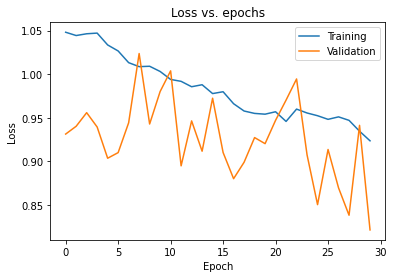

In [59]:
plt.plot(MLP_history.history['loss'])
plt.plot(MLP_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

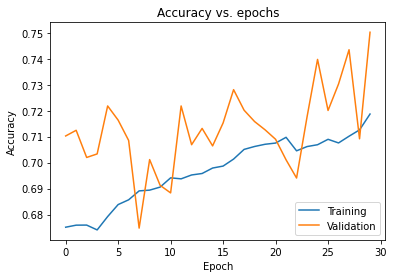

In [60]:
plt.plot(MLP_history.history['accuracy'])
plt.plot(MLP_history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [61]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test MLP Model loss: {loss}")
print(f"Test MLP Model accuracy: {accuracy}")

814/814 [==============================] - 3s 4ms/step - loss: 0.9178 - accuracy: 0.7254
Test MLP Model loss: 0.9178130626678467
Test MLP Model accuracy: 0.7253764867782593


In [62]:
def get_CNN_model(input_shape):

    model = Sequential([
        Conv2D(filters=64, input_shape=input_shape, kernel_size=(3, 3), padding="same",
               activation='relu', name='conv_1'),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', name='conv_2'),
        BatchNormalization(),
        Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation='relu', name='conv_3'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dense(units=10, activation='softmax', name='dense_2')
    ])

    return model

In [63]:
CNN_model = get_CNN_model(x_train[0].shape)
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv_3 (Conv2D)             (None, 32, 32, 16)        4624      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 16)      

In [64]:
CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [65]:
checkpoint_CNN_best_path = 'checkpoints_CNN_best_only/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_CNN_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [66]:
CNN_history = CNN_model.fit(x_train, y_train, epochs=30,
                            validation_split=0.15, batch_size=64, verbose=1,
                            callbacks=[early_stopping, checkpoint_best])

Epoch 1/30
973/973 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.7458
Epoch 1: val_accuracy improved from -inf to 0.82746, saving model to checkpoints_CNN_best_only\checkpoint
973/973 [==============================] - 18s 12ms/step - loss: 0.8244 - accuracy: 0.7458 - val_loss: 0.5753 - val_accuracy: 0.8275
Epoch 2/30
967/973 [============================>.] - ETA: 0s - loss: 0.4599 - accuracy: 0.8627
Epoch 2: val_accuracy did not improve from 0.82746
973/973 [==============================] - 9s 9ms/step - loss: 0.4593 - accuracy: 0.8628 - val_loss: 0.6065 - val_accuracy: 0.8197
Epoch 3/30
972/973 [============================>.] - ETA: 0s - loss: 0.3980 - accuracy: 0.8807
Epoch 3: val_accuracy improved from 0.82746 to 0.85849, saving model to checkpoints_CNN_best_only\checkpoint
973/973 [==============================] - 10s 10ms/step - loss: 0.3979 - accuracy: 0.8807 - val_loss: 0.4625 - val_accuracy: 0.8585
Epoch 4/30
971/973 [============================>

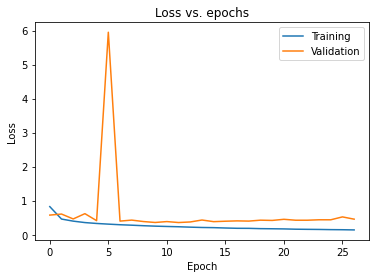

In [67]:
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

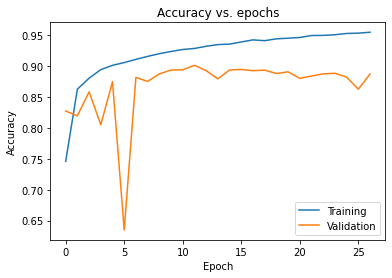

In [68]:
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

In [69]:
loss, accuracy = CNN_model.evaluate(x_test, y_test)
print(f"Test CNN model loss: {loss}")
print(f"Test CNN model accuracy: {accuracy}")

814/814 [==============================] - 3s 3ms/step - loss: 0.4823 - accuracy: 0.8780
Test CNN model loss: 0.4823009669780731
Test CNN model accuracy: 0.8779963254928589


In [84]:
checkpoint_best_path = 'checkpoints_MLP_best_only/checkpoint'
model = get_MLP_model(x_train[0].shape, 1e-5, 0.3)
model.load_weights(checkpoint_best_path)

In [85]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

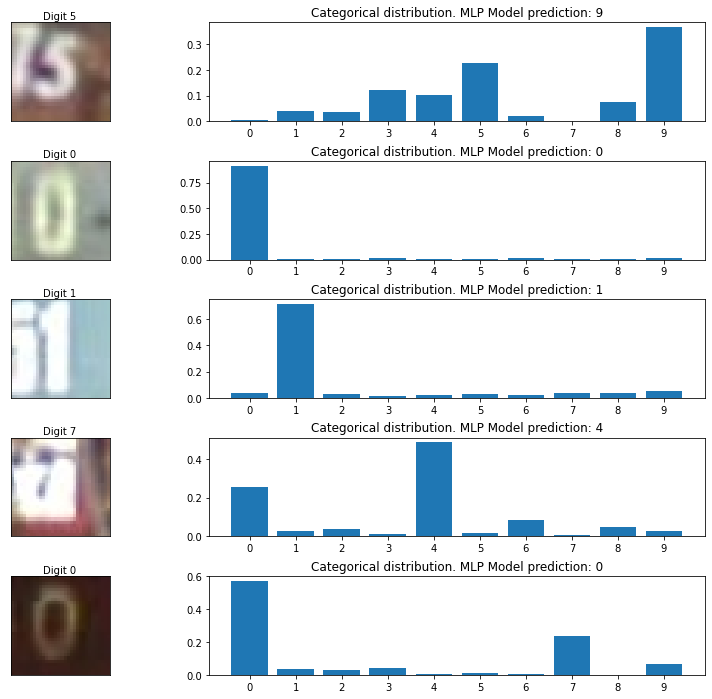

In [86]:
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. MLP Model prediction: {np.argmax(prediction)}")
    
plt.show()

In [87]:
model.save('models/SVHN_MLP_best_001.h5')

In [89]:
checkpoint_best_path = 'checkpoints_CNN_best_only/checkpoint'
model = get_CNN_model(x_train[0].shape)
model.load_weights(checkpoint_best_path)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

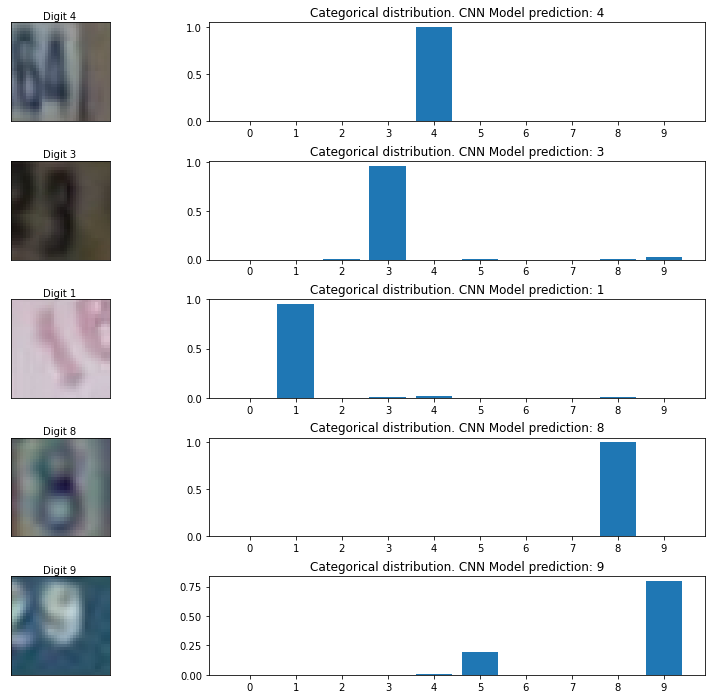

In [90]:
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap='gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. CNN Model prediction: {np.argmax(prediction)}")
    
plt.show()

In [91]:
model.save('models/SVHN_CNN_best_001.h5')